## Load packages and data

In [114]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.inspection import plot_partial_dependence
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from modeling_utils import get_classifier_scores, get_classifier_performance, get_feature_names

In [76]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
df = pickle.load(open("processed_data.pickle", "rb"))

## Model 1: "Conduct Occurred" ruling
This model will apply to the entire dataset, and try to predict whether the CCRB determines that a complaint did occur (i.e. was ruled "substantiated" or "exonerated").

### Define features + target,  preprocessing steps and to train/test split

In [78]:
# define features and target
features_list = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'complaint_is_grouped',
                 'officer_cumcount', 'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean', 'mos_ethnicity',
                 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'contact_reason', 
                 'outcome_description']

X1 = df[features_list]
y1 = df['ruling_conduct_occurred']

In [79]:
# define numeric and categorical features
numeric_features = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'officer_cumcount',
                    'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean']
categorical_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender',
                        'fado_type', 'contact_reason', 'outcome_description']

In [80]:
# create preprocessor pipeline steps to process numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combine into final preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [81]:
# split data into training and test set
X1, X1_test, y1, y1_test = train_test_split(
    X1, y1, test_size=.2, random_state=33,stratify=y1) 

### Try a bunch of classifiers with cross-validation

In [82]:
clf_models_list = [
    LogisticRegression(max_iter=500),
    RandomForestClassifier(random_state=33),
    KNeighborsClassifier(3),
    SVC(random_state=33),
    GradientBoostingClassifier(random_state=33),
    GaussianNB()
    ]

In [83]:
# test the same set of classifiers using same preprocessing techniques
get_classifier_scores(X1,y1,clf_models_list,preprocessor)

LogisticRegression(max_iter=500)
0.6172863905896246
RandomForestClassifier(random_state=33)
0.6691976538372156
KNeighborsClassifier(n_neighbors=3)
0.6281450766195885
SVC(random_state=33)
0.6339721993643983
GradientBoostingClassifier(random_state=33)
0.634943365376511
GaussianNB()
0.6047054897266464


Looks like Random Forest fits my data best of the models tried. Now I'll examine some additional metrics and then see if I can optimize the model.

### Baseline Random Forest Performance Metrics

              precision    recall  f1-score   support

           0       0.67      0.63      0.64     10872
           1       0.67      0.71      0.69     11782

    accuracy                           0.67     22654
   macro avg       0.67      0.67      0.67     22654
weighted avg       0.67      0.67      0.67     22654



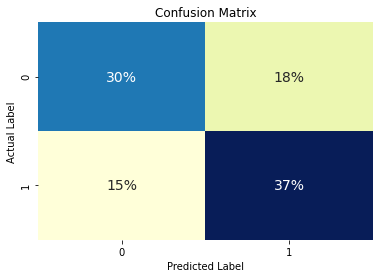

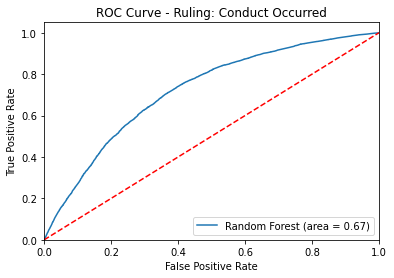

In [84]:
# evaluate Random Forest performance with default hyperparameters
get_classifier_performance(X=X1,y=y1,model=RandomForestClassifier(),preprocessor=preprocessor)

### Hyperparameter Tuning
Running GridSearchCV on my random forest model to see if performance can be improved

In [86]:
# Number of trees in random forest
n_estimators = [100,125,150,175,200] 

# Number of features to consider at every split
max_features = ['auto','log2']

# Maximum number of levels in tree
max_depth = [4,5,6,7,8]

# Create the random grid
param_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth}
pprint(param_grid) 

{'classifier__max_depth': [4, 5, 6, 7, 8],
 'classifier__max_features': ['auto', 'log2'],
 'classifier__n_estimators': [100, 125, 150, 175, 200]}


In [87]:
# create the baseline model to tune
rf1 = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier())])

# run random search cross validation
rf1_grid = GridSearchCV(estimator = rf1, param_grid = param_grid, verbose=1)

In [88]:
# fit the grid search model
rf1_grid.fit(X1, y1) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.2min finished


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mos_age_incident',
                                                                          'complainant_age_incident',
                                                                          'complaint_age',
                                                                          'officer_cumcount',
                                              

In [89]:
# get the best parameters from the grid search
rf1_grid.best_params_

{'classifier__max_depth': 8,
 'classifier__max_features': 'auto',
 'classifier__n_estimators': 200}

              precision    recall  f1-score   support

           0       0.70      0.40      0.51     10872
           1       0.60      0.84      0.70     11782

    accuracy                           0.63     22654
   macro avg       0.65      0.62      0.61     22654
weighted avg       0.65      0.63      0.61     22654



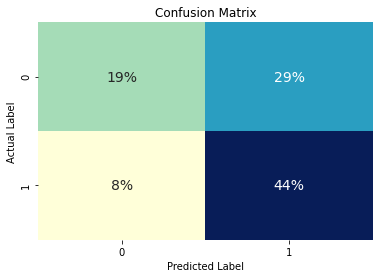

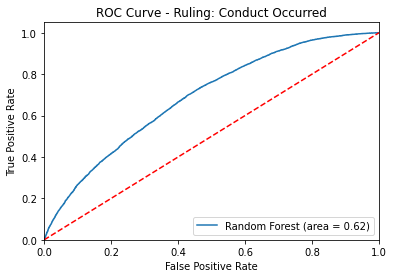

In [90]:
# test new parameters
get_classifier_performance(X=X1,y=y1,model=RandomForestClassifier(n_estimators=125, max_depth=8,max_features='auto'),
                           preprocessor=preprocessor)

Welp, looks like the parameters that grid search yielded did NOT help my model performance. It's possible that grid search is overfitting, or I should be doing more to ensure the cross validation samples are well balanced. In any case, for now I'll stick with the default RF parameters for my final model.

### Final Model Fit and Evaluation

In [91]:
# Evaluate performance on holdout test data
rf1_final = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])
rf1_final.fit(X1,y1)

y1_test_pred = rf1_final.predict(X1_test)

print(classification_report(y1_test,y1_test_pred))

              precision    recall  f1-score   support

           0       0.68      0.63      0.66      2718
           1       0.68      0.73      0.71      2946

    accuracy                           0.68      5664
   macro avg       0.68      0.68      0.68      5664
weighted avg       0.68      0.68      0.68      5664



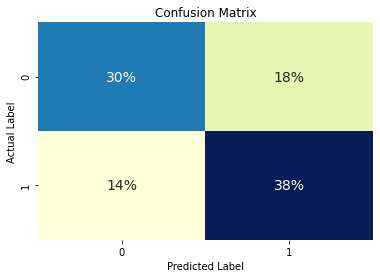

In [92]:
# print confusion matrix
cf_matrix = confusion_matrix(y1_test,y1_test_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.0%', cmap='YlGnBu', annot_kws={"fontsize":14}, cbar = False)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix');

## Model 2: "Violated Rules" ruling
This model will apply only to complaints that the CCRB determined _did_ occur, and try to predict whether the complaint is ruled "substantiated" (the officer's conduct violated rules) or "exonerated" (the officer's conduct did not violate NYPD rules).\

### Define features + target,  preprocessing steps and to train/test split
Will use the same set of preprocessing steps as Model 1, since features are the same.

In [93]:
# filter out any "unsubstantiated" complaints and save as new dataframe
indexNames = df[df['disposition_clean'] == 'Unsubstantiated'].index
df2 = df.drop(indexNames)

# define X and y for 'violated rules' model
X2 = df2[features_list]
y2 = df2['ruling_conduct_violated_rules']

In [94]:
# split into training and test set
X2, X2_test, y2, y2_test = train_test_split(
    X2, y2, test_size=.2, random_state=33) 

### Try a bunch of classifiers with cross validation

In [95]:
# test the same set of classifiers using same preprocessing techniques
get_classifier_scores(X2,y2,clf_models_list,preprocessor)

LogisticRegression(max_iter=500)
0.6907998642918216
RandomForestClassifier(random_state=33)
0.7530133122231721
KNeighborsClassifier(n_neighbors=3)
0.687574381983947
SVC(random_state=33)
0.7087091299765969
GradientBoostingClassifier(random_state=33)
0.716262507446302
GaussianNB()
0.594296078653118


Looks like Random Forest is fitting my data best. Now I'll check to see whether it can be optimized.

### Baseline Random Forest Performance Metrics

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      6222
           1       0.74      0.74      0.74      5560

    accuracy                           0.75     11782
   macro avg       0.75      0.75      0.75     11782
weighted avg       0.75      0.75      0.75     11782



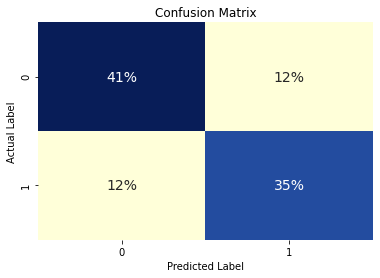

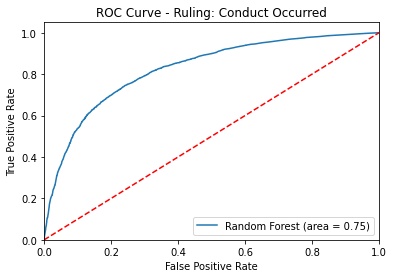

In [96]:
get_classifier_performance(X=X2,y=y2,model=RandomForestClassifier(),preprocessor=preprocessor)

### Hyperparameter Tuning

In [97]:
# I'll use the same grid parameter as above, since both models have the same features

# create the baseline model to tune
rf2 = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier())])

# run random search cross validation
rf2_grid = GridSearchCV(estimator = rf2, param_grid = param_grid, verbose=1)

In [98]:
# fit the grid search model
rf2_grid.fit(X2, y2) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.0min finished


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['mos_age_incident',
                                                                          'complainant_age_incident',
                                                                          'complaint_age',
                                                                          'officer_cumcount',
                                              

In [99]:
# get the best parameters from the grid search
rf1_grid.best_params_

{'classifier__max_depth': 8,
 'classifier__max_features': 'auto',
 'classifier__n_estimators': 200}

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      6222
           1       0.67      0.75      0.71      5560

    accuracy                           0.71     11782
   macro avg       0.71      0.71      0.71     11782
weighted avg       0.71      0.71      0.71     11782



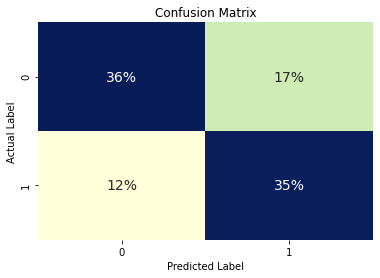

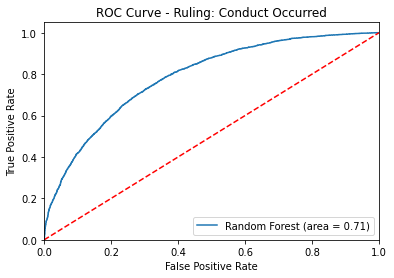

In [100]:
get_classifier_performance(X=X2,y=y2,model=RandomForestClassifier(n_estimators=125, max_depth=8,max_features='auto'),
                           preprocessor=preprocessor)

Same story as above; the grid search did not help me find a model that performs better. Will stick with RF's out of the box configuration.

### Final Model Fit and Evaluation

In [101]:
# Evaluate performance on holdout test data
rf2_final = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])
rf2_final.fit(X2,y2)

y2_test_pred = rf2_final.predict(X2_test)

print(classification_report(y2_test,y2_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1526
           1       0.77      0.76      0.77      1420

    accuracy                           0.78      2946
   macro avg       0.78      0.78      0.78      2946
weighted avg       0.78      0.78      0.78      2946



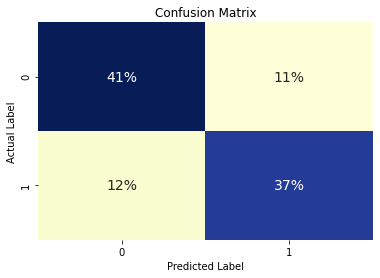

In [102]:
# print confusion matrix
cf_matrix = confusion_matrix(y2_test,y2_test_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.0%', cmap='YlGnBu', annot_kws={"fontsize":14}, cbar = False)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix');

### Explore Feature Importance of Final model
For feature importance, I'm choosing to only explore model 2. I'm excluding model 1 because there are myriad unpredictable reasons why a case could be ruled unsubstantiated (e.g. missing evidence, unresponsive complainant, etc.) so it's a noisier problem -- likely why overall performance was lower for that model.

In [103]:
# extract feature names and importance from model and save as dataframe
feature2_importance = pd.DataFrame(rf2_final.named_steps['classifier'].feature_importances_.flatten(), 
                                  index=get_feature_names(preprocessor))

# print feature names and importance
feature2_importance = feature2_importance.sort_values(0,ascending=False)
feature2_importance[:20]

,0
num__complaint_age,0.148482
num__complainant_age_incident,0.100612
num__percent_unemployed_mean,0.087373
num__percent_nohs_mean,0.086724
num__mos_age_incident,0.085787
onehot__x4_Force,0.069504
num__officer_cumcount,0.064596
onehot__x6_Arrest,0.028361
num__command_rank_num,0.026545
onehot__x6_None,0.026508


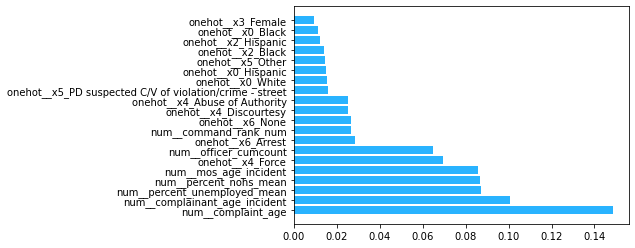

In [111]:
# plot feature importance
plt.barh(y=feature2_importance.index[:20],width=feature2_importance[0][:20],color='#29B3FF');

Note: credit to [Johannes Haupt](https://johaupt.github.io/scikit-learn/tutorial/python/data%20processing/ml%20pipeline/model%20interpretation/columnTransformer_feature_names.html) for the get_feature_names function.

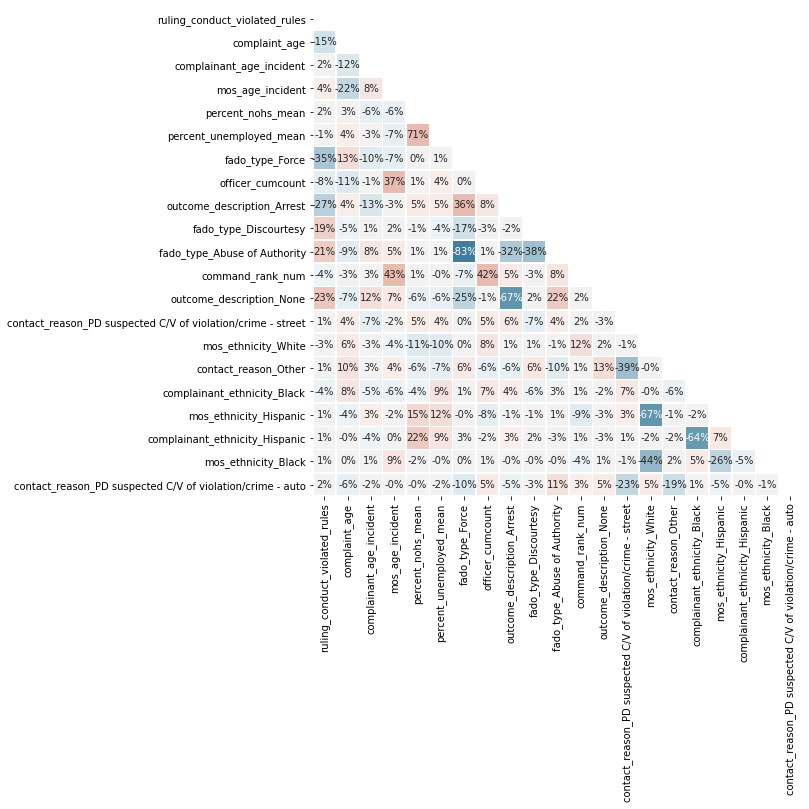

In [112]:
# create heatmap of most important features to understand directional impact

# first need nicely named dummy variables
df2_dummies = pd.get_dummies(df2, columns=['mos_ethnicity','mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 
                                         'contact_reason', 'outcome_description'])
df2_dummies.columns

corr_features = ['ruling_conduct_violated_rules','complaint_age', 'complainant_age_incident', 'mos_age_incident',
                 'percent_nohs_mean', 'percent_unemployed_mean', 'fado_type_Force', 'officer_cumcount',
                 'outcome_description_Arrest', 'fado_type_Discourtesy', 'fado_type_Abuse of Authority',
                 'command_rank_num', 'outcome_description_None', 'contact_reason_PD suspected C/V of violation/crime - street',
                 'mos_ethnicity_White', 'contact_reason_Other', 'complainant_ethnicity_Black', 'mos_ethnicity_Hispanic',
                 'complainant_ethnicity_Hispanic', 'mos_ethnicity_Black', 'contact_reason_PD suspected C/V of violation/crime - auto']
                 
# plot correlation matrix
corr2 = df2_dummies[corr_features].corr()
mask = np.triu(np.ones_like(corr2, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(data=corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True,fmt='.0%', annot_kws={"fontsize":10},cbar=False);               
                 